# ARIMA Modelling

An ARIMA (AutoRegressive Integrated Moving Average) model is a statistical method used for time series forecasting. It combines autoregressive (AR), differencing (I), and moving average (MA) components to capture the underlying patterns and dependencies in a time series dataset, based on historical values of the target.

## Stationarity

ARIMA can only be used to model stationary data. If the data is not stationary then it must be converted to stationary. This can be done by calculating the difference.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quickly. If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# Read in the LOB Data
lob_df = pd.read_csv('data/output/EDA_lob_output_data_sample.csv')

# Check df

lob_df.head()

,Timestamp,Exchange,Bid,Ask,Date,Mid_Price
0,0.000,Exch0,[],[],2025-01-02,NaN
1,0.279,Exch0,"[[1, 6]]",[],2025-01-02,NaN
2,1.333,Exch0,"[[1, 6]]","[[800, 1]]",2025-01-02,400.5
3,1.581,Exch0,"[[1, 6]]","[[799, 1]]",2025-01-02,400.0
4,1.643,Exch0,"[[1, 6]]","[[798, 1]]",2025-01-02,399.5


In [3]:
# Take a single dates data to allow processing locally
# Order date byt date and timestamp
lob_df.sort_values(by=['Date','Timestamp'], ascending=True, inplace=True)

# Select single date
filtered_lob_df = lob_df[lob_df['Date']=='2025-01-02']

Test whether the mid-price is stationary or not using the Augmented Dickey Fuller (ADF) test. The ADF test is a statistical significance test where the null hypothesis assumes the presence of unit root, infering the data is non-stationary. Therefore if the p-value is less than 0.05 the null hypothesis is rejected and inferring that the series is stationary. Whilst if the p-value is greater than 0.05 the null hypothesis is accepted inferring the data is non-stationary.

In [4]:
# Extract the 'Mid_Price' column
mid_price_series = filtered_lob_df['Mid_Price']

# dropna() to handle any missing values
mid_price_series.dropna(inplace=True)

C:\Users\Jack\AppData\Local\Temp\ipykernel_1480\1212423413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_price_series.dropna(inplace=True)


In [5]:
# Perform the ADF test
result = adfuller(mid_price_series, autolag='AIC')  

# Print the ADF test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Number of Lags:', result[2])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -31.636222776242892
p-value: 0.0
Number of Lags: 93
Critial Values:
   1%, -3.4303685320987882
Critial Values:
   5%, -2.861548190962006
Critial Values:
   10%, -2.566774359751182


The P value is 0.0 and the ADF statistic is significantly lower than the critical values therefore the null hypothesis is rejected and inferring the data is stationary.

__We will need to re-run this on the full dataset to ensure it is infact stationary, and once we have delt with the noisy mid-point as I think this will likely give us a different reading when it comes to stationarity.__

In [6]:
# pip install statsmodels -U


In [7]:
# As the data in this sample is deemed stationary we do not need to determine the lags.

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':150})

# # Original Series
# fig, axes = plt.subplots(3, 2)
# axes[0, 0].plot(mid_price_series); axes[0, 0].set_title('Original Series')
# plot_acf(mid_price_series, lags=10, ax=axes[0, 1])

# # 1st Differencing
# axes[1, 0].plot(mid_price_series.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(mid_price_series.diff().dropna(), lags=10, ax=axes[1, 1])

# # 2nd Differencing
# axes[2, 0].plot(mid_price_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(mid_price_series.diff().diff().dropna(), lags=10, ax=axes[2, 1])

# plt.show()

## Identifying the Order of the AR term

The next step is to identify if the model needs any AR terms. This can be determined by inspecting the Partial Autocorrelation (PACF) plot. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. PACF conveys the pure correlation between a lag and the series. Therefore it help determine if lag is needed in the AR term or not.

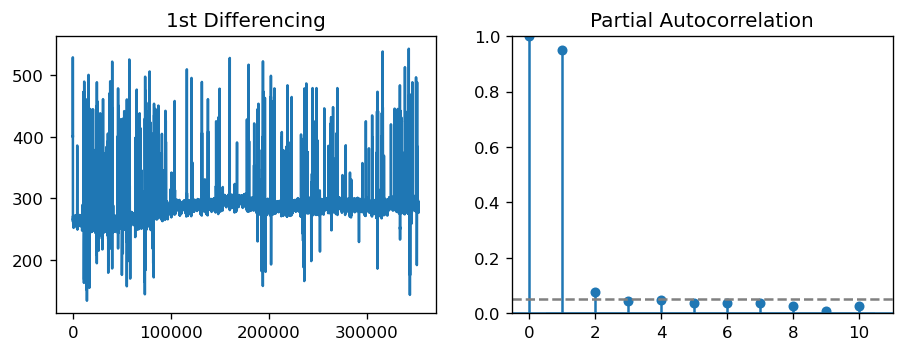

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF plot of the mid-price series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(mid_price_series); axes[0].set_title('original')
axes[1].set(ylim=(0,5))
plot_pacf(mid_price_series, lags=10, ax=axes[1], alpha=0.05)
axes[1].set(ylim=(0,1))
# Set significance lines -- check if this is correct
plt.axhline(y=0.05, linestyle='--', color='gray') # Upper significance line
plt.axhline(y=-0.05, linestyle='--', color='gray') # Lower significance line
plt.show()

From the PACF plot we can see that both the 1st and second lags are significant. Therefore the AR term can be fixed at 2.

## Identifying the Order of the MA term

The MA terms can be delected by inspecting the ACF plot.

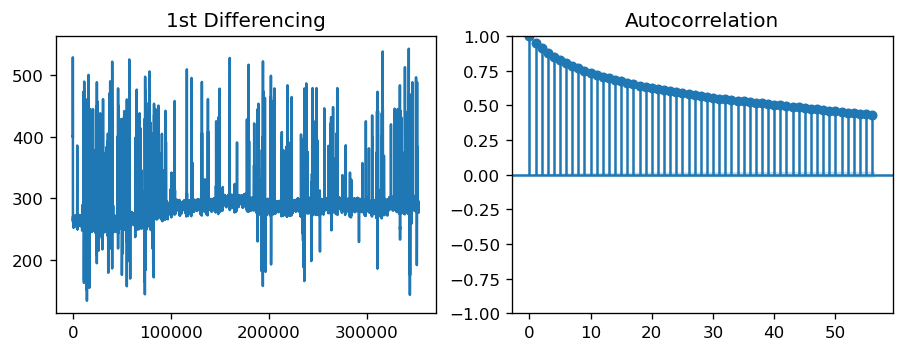

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(mid_price_series); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(mid_price_series, ax=axes[1])

plt.show()

The significance levels are hard to determine from the figures, I am going to attemot to run auto_arima instead. This should propose the optimal arima set up for the dataset.

In [10]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [11]:
from pmdarima.arima import auto_arima, ADFTest

In [12]:
# Test stationarity with a 0.05 significance level

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(mid_price_series)

(0.01, False)

Interestingly this suggests the data is non-stationary which is not the same as the previous result.

In [13]:
# Split data into test and train splits

train = mid_price_series[:(len(mid_price_series)/4)*3]
test = mid_price_series[-len(mid_price_series)/4:]

plt.plot(train)
plt.plot(test)

TypeError: cannot do slice indexing on Index with these indexers [264720.0] of type float

## Calcualte Moving Average to remove noise, for use in Arima

In [13]:
window_size = 5
 
i = 0
# Initialize an empty list to store moving averages
mp_moving_averages = []
 
# Loop through the array to consider
# every window of size 3
while i < len(mid_price_series) - window_size + 1:
   
    # Store elements from i to i+window_size
    # in list to get the current window
    window = mid_price_series[i : i + window_size]
 
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
     
    # Store the average of current
    # window in moving average list
    mp_moving_averages.append(window_average)
     
    # Shift window to right by one position
    i += 1

In [14]:
mp_moving_averages[:5]

[451.7, 431.5, 407.3, 383.3, 333.2]

In [15]:
# Perform the ADF test
result = adfuller(mp_moving_averages, autolag='AIC')  

# Print the ADF test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Number of Lags:', result[2])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -31.117593343832358
p-value: 0.0
Number of Lags: 93
Critial Values:
   1%, -3.4303685323088673
Critial Values:
   5%, -2.861548191054858
Critial Values:
   10%, -2.5667743598006036


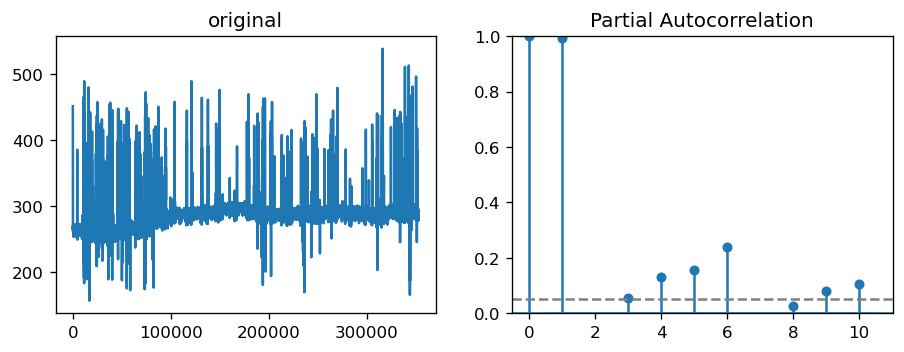

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF plot of the mid-price series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(mp_moving_averages); axes[0].set_title('original')
axes[1].set(ylim=(0,5))
plot_pacf(mp_moving_averages, lags=10, ax=axes[1], alpha=0.05)
axes[1].set(ylim=(0,1))
# Set significance lines -- check if this is correct
plt.axhline(y=0.05, linestyle='--', color='gray') # Upper significance line
plt.axhline(y=-0.05, linestyle='--', color='gray') # Lower significance line
plt.show()